This Notebook contains my process through creating my first algorithmic trading bot, I guess its my "Hello World" for this project. So during this notebook I probably have no clue what I'm doing, but I hope theres clear progress from this notebook to future entries in the project. My favorite ticker to look at is the NQ future, so thats what I'll do the project on.

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pytz
from backtesting import Backtest, Strategy
from IPython .display import Image

### Importing Data
Getting data from yahoo finance data api

In [35]:
#nqdf = yf.download('NQ=F', start='2025-02-4', end='2025-04-1', interval='15m')
#nqdf.columns = nqdf.columns.get_level_values(0)
#Importing finished cv since these dates will not be stored in yfinance after 60 days passes
nqdf = pd.read_csv('marketdata/nqdf_15min_2024-02-4_2025-04-1.csv')

In [36]:
nqdf

,Close,High,Low,Open,Volume,Signal,EMA,MACD,Signal_Line,MACD_Hist
0,21306.00,21348.50,21289.00,21301.50,1470,0,21306.000000,0.000000,0.000000,0.000000
1,21334.50,21344.25,21242.50,21302.50,4369,0,21308.590909,2.273504,0.454701,1.818803
2,21352.50,21361.50,21317.75,21333.50,2149,0,21312.582645,5.464728,1.456706,4.008022
3,21358.25,21410.00,21344.00,21354.25,2405,0,21316.734222,8.361389,2.837643,5.523746
4,21359.75,21374.75,21337.50,21359.25,1395,0,21320.644748,10.655223,4.401159,6.254064
...,...,...,...,...,...,...,...,...,...,...
3554,19380.00,19381.75,19364.75,19366.25,939,0,19350.019684,8.767421,9.419075,-0.651654
3555,19378.25,19386.75,19373.50,19380.25,778,0,19352.586076,10.031933,9.541647,0.490286
3556,19371.50,19379.25,19367.50,19379.25,665,0,19354.305524,10.369861,9.707290,0.662572
3557,19360.25,19374.25,19354.50,19372.50,1168,0,19354.845931,9.619009,9.689634,-0.070624


Signal: Engulfing Candle
This is probably the most basic signal there is. Its simply when the following candle opens and closes below the previous (for a bearish indicator, opposite for bullish)  
<img src="pictures/engulfingpic.jpg" alt="description" style="display:block;margin:auto" width="300" height="200"/>


In [37]:
def engulf_signal(df):
    """
    Generate buy/sell signals based on the closing prices of the candles. If the 2nd candle in a sequence closes below or above
    the opening price of the candle before, the signal will occur.
    For a sell signal, the closing price of the 2nd candle must be below the opening price of the previous candle and the function will return 1.
    For a buy signal, the closing price of the 2nd candle must be above the opening price of the previous candle and the function will return 2.
    No signal returns 0
    """
    open_ = float(df.Open.iloc[-1])
    close_ = float(df.Close.iloc[-1])
    prev_open = float(df.Open.iloc[-2])
    prev_close = float(df.Close.iloc[-2])

    #Sell signal
    if (open_>close_ and
        prev_open<prev_close and
        close_<prev_open and
        open_>=prev_close):
        return 1

    #Buy signal
    elif (open_<close_ and
          prev_open>prev_close and
          close_>prev_open and
          open_<=prev_close):
        return 2
    
    #No signal
    else:
        return 0

In [38]:
#Checking through our df for signals
signal = []
signal.append(0)
for i in range(1, len(nqdf)):
    data = nqdf.iloc[i-1:i+1]
    signal.append(engulf_signal(data))
nqdf['Signal'] = signal

In [39]:
nqdf.Signal.value_counts()

Signal
0    3078
1     252
2     229
Name: count, dtype: int64

In [40]:
nqdf.Close.iloc[0]

np.float64(21306.0)

Plotting the signals on a chart

In [41]:
def plot_candlestick_signals(df, day=None, start_time=None, end_time=None):
    """
    Plot candlestick chart with engulfing buy/sell signals for a specific day and optional time range.
    
    Parameters:
        df (DataFrame): OHLC dataframe with a datetime index and a 'Signal' column.
        day (str or datetime.date, optional): The date to plot (e.g., '2025-03-10').
        start_time (str, optional): Start time (e.g., '09:30') in HH:MM format.
        end_time (str, optional): End time (e.g., '16:00') in HH:MM format.
    """
    df = df.copy()
    df.index = pd.to_datetime(df.index)
    df = df.dropna(subset=['Open', 'High', 'Low', 'Close'])

    # Filter by day
    if day is not None:
        day = pd.to_datetime(day).date()
        df = df[df.index.date == day]

    # Filter by time range
    if start_time or end_time:
        # Convert to datetime.time objects
        if start_time:
            start_time = pd.to_datetime(start_time).time()
        if end_time:
            end_time = pd.to_datetime(end_time).time()

        df = df[(df.index.time >= (start_time or df.index.time.min())) &
                (df.index.time <= (end_time or df.index.time.max()))]

    if df.empty:
        print("No data for the specified day/time range.")
        return

    # Plot
    fig = go.Figure()

    fig.add_trace(go.Candlestick(
        x=df.index,
        open=df['Open'],
        high=df['High'],
        low=df['Low'],
        close=df['Close'],
        name='Candles'
    ))

    # Sell signals
    sell_signals = df[df['Signal'] == 1]
    fig.add_trace(go.Scatter(
        x=sell_signals.index,
        y=sell_signals['High'],
        mode='markers',
        marker=dict(color='red', symbol='triangle-down', size=10),
        name='Sell Signal'
    ))

    # Buy signals
    buy_signals = df[df['Signal'] == 2]
    fig.add_trace(go.Scatter(
        x=buy_signals.index,
        y=buy_signals['Low'],
        mode='markers',
        marker=dict(color='green', symbol='triangle-up', size=10),
        name='Buy Signal'
    ))

    fig.update_layout(
        title=f'NQ=F Candlestick Chart with Signals ({day})',
        xaxis_title='Time',
        yaxis_title='Price',
        xaxis_rangeslider_visible=False,
        template='plotly_dark',
        height=700
    )

    fig.show('notebook')


In [42]:
plot_candlestick_signals(nqdf, day='2025-03-10')

No data for the specified day/time range.


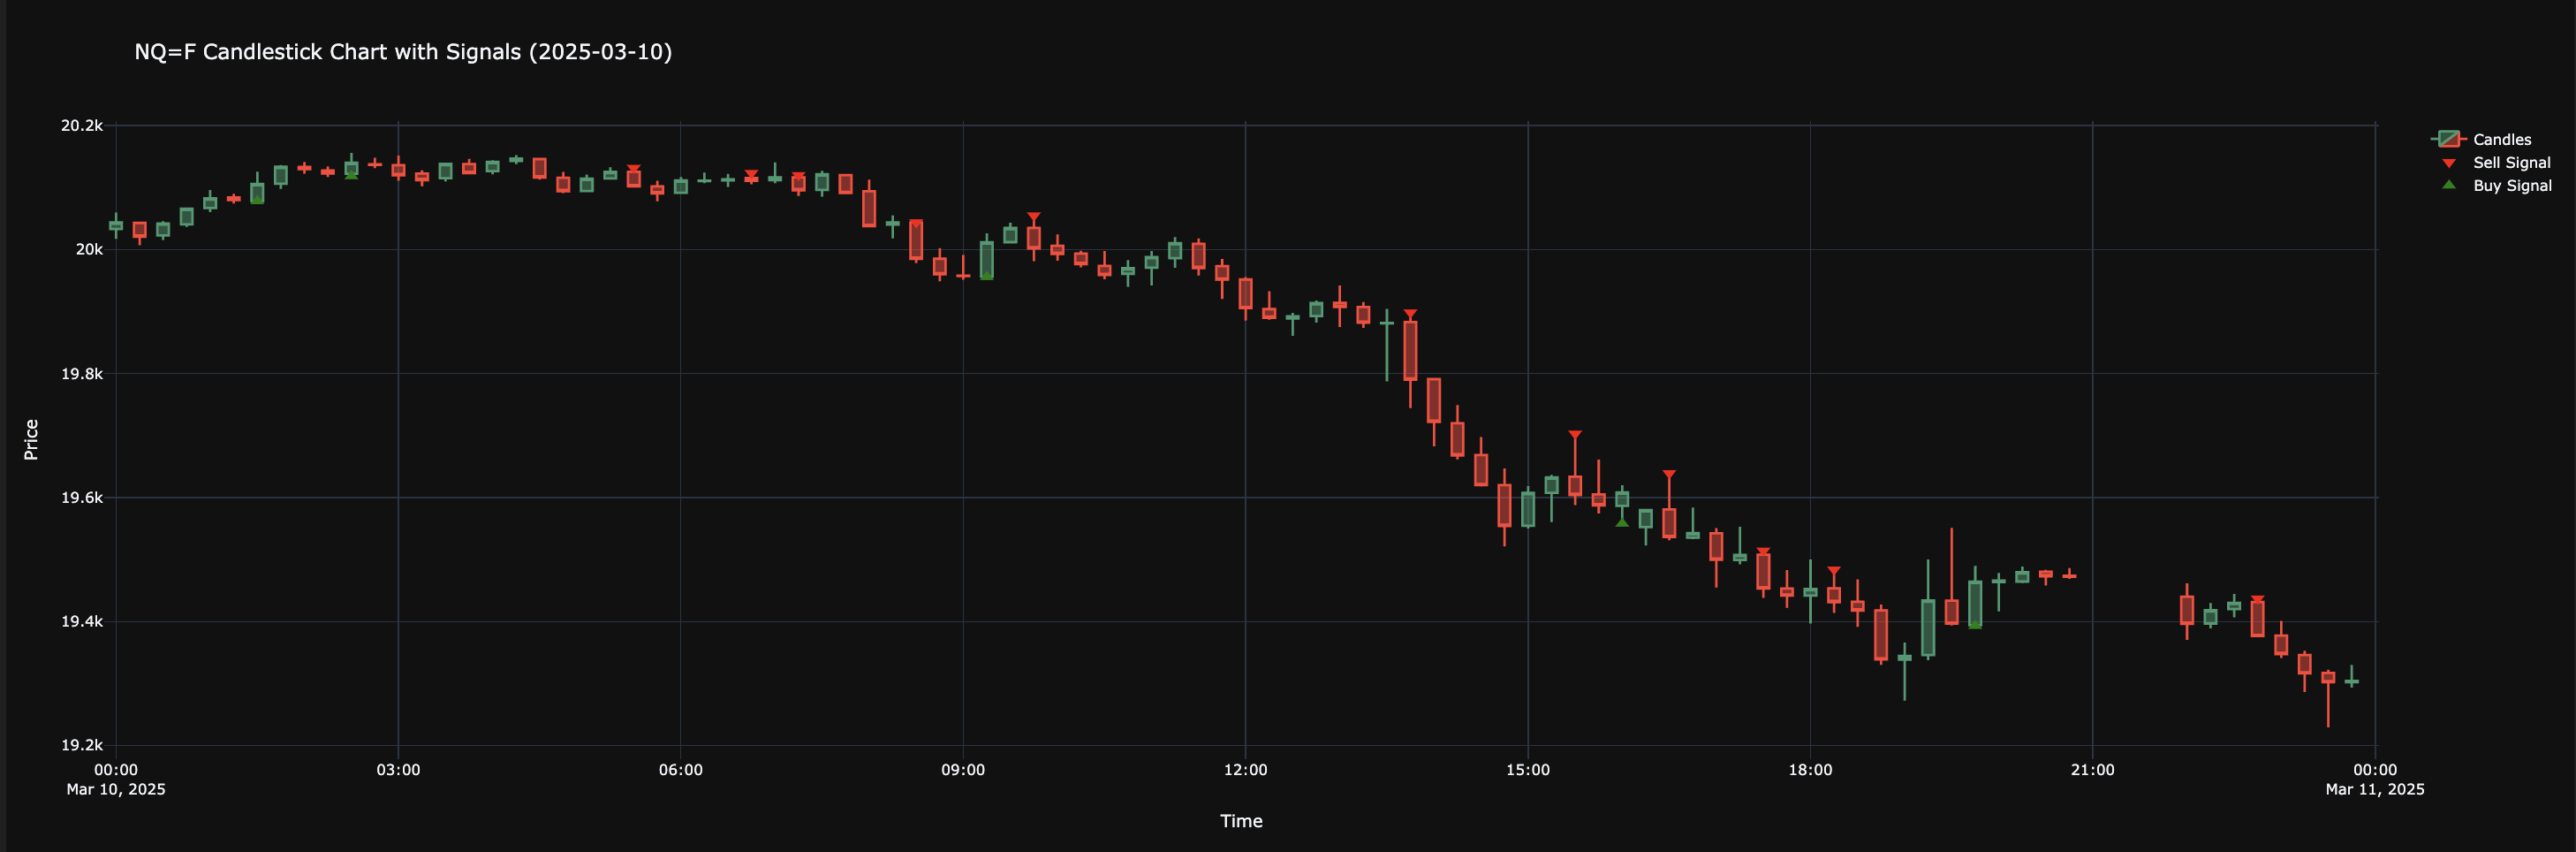

In [43]:
Image(filename= "graphsforgit/c3.png")

This signal obviously should not be used by itself. Lets see what it's PNL would've been

### Backtesting
Instead of below, I found the backtesting.py library which is insanely useful, and will save so much time. But below was just a super simple backtesting function

In [44]:
entry_price = None
position = 0
pnl_list = []

stop_loss = 50
profit_target = 100

#setting date and time parameters
date = '2025-03-10'
start_time = ''
end_time = ''

# Filter the dataframe for the specified date and time range function, with date and time optional

def filter_df_by_date_time(df, date=None, start_time=None, end_time=None):
    """
    Filter the dataframe based on a specific date and optional time range.
    
    Parameters:
        df (DataFrame): DataFrame with a datetime index.
        date (str or datetime.date, optional): The date to filter (e.g., '2025-03-10').
        start_time (str, optional): Start time (e.g., '09:30') in HH:MM format.
        end_time (str, optional): End time (e.g., '16:00') in HH:MM format.
    
    Returns:
        DataFrame: Filtered DataFrame.
    """
    df = df.copy()
    df.index = pd.to_datetime(df.index)

    # Filter by date
    if date is not None:
        date = pd.to_datetime(date).date()
        df = df[df.index.date == date]

    # Filter by time range
    if start_time or end_time:
        # Convert to datetime.time objects
        if start_time:
            start_time = pd.to_datetime(start_time).time()
        if end_time:
            end_time = pd.to_datetime(end_time).time()

        df = df[(df.index.time >= (start_time or df.index.time.min())) &
                (df.index.time <= (end_time or df.index.time.max()))]

    return df


df_filtered = filter_df_by_date_time(nqdf, date = date)


In [45]:
for i in range(len(df_filtered)):
    current_row = df_filtered.iloc[i]
    current_signal = current_row['Signal']
    current_price = current_row['Close']

    # Check for buy signal
    if current_signal == 2 and position == 0:
        entry_price = current_price
        position = 1
        print(f"Buy at {entry_price} on {current_row.name}")

    # Check for sell signal
    elif current_signal == 1 and position == 0:
        entry_price = current_price
        position = -1
        print(f"Sell at {entry_price} on {current_row.name}")

    # Check for stop loss or profit target
    if position == 1:
        if (current_price - entry_price) >= profit_target:
            print(f"Take profit at {current_price} on {current_row.name}")
            pnl_list.append(profit_target)
            entry_price = None
            position = 0
        elif (entry_price - current_price) >= stop_loss:
            print(f"Stop loss at {current_price} on {current_row.name}")
            pnl_list.append(-stop_loss)
            entry_price = None
            position = 0

    elif position == -1:
        if (entry_price - current_price) >= profit_target:
            print(f"Take profit at {current_price} on {current_row.name}")
            pnl_list.append(profit_target)
            entry_price = None
            position = 0
        elif (current_price - entry_price) >= stop_loss:
            print(f"Stop loss at {current_price} on {current_row.name}")
            pnl_list.append(-stop_loss)
            entry_price = None
            position = 0
# Calculate the total PnL
total_pnl = sum(pnl_list)
print(f"Total PnL: {total_pnl}")


Total PnL: 0


#### Now, before diving into using machine learning models to detect candlestick patterns. I want to have a good understanding of all the other commonly used indicators (i.e. EMA, MACD, RSI, VWAP)

### First we have EMA, an Exponential moving average.
$(\text{EMA})_t = \alpha \cdot P_t + (1-\alpha) \cdot EMA_{t-1}$, where  
* $P_t:$ is the price at time t (the last bar close since ema lags one candle behind)
* $\alpha:$ is the smoothing factor. Usually computed as $\frac{2}{n+1}$ where $n$ is the period length you want
* $\text{EMA}_{t-1}$ is just the previous EMA.  

Super simple but it can be seen as one of the pillars of technical analysis. It depicts trend better than something like an SMA since recent prices matter more than an SMA-- allowing it to react to trend reversals or spikes faster

In [46]:
#Adding EMA to the dataframe
def add_ema(df, period = 21):
    """
    Add Exponential Moving Average (EMA) to the dataframe.
    
    Parameters:
        df (DataFrame): DataFrame with 'Close' column.
        period (int): Period for EMA calculation.
    
    Returns:
        DataFrame: DataFrame with EMA column added.
    """
    df['EMA'] = df['Close'].ewm(span=period, adjust=False).mean()
    return df
nqdf = add_ema(nqdf, period=21)

In [47]:
def plot_candlestick_with_ema(df, day=None, start_time=None, end_time=None):
    # Plot candlestick chart with EMA for a specific day and optional time range.
    df = df.copy()
    df.index = pd.to_datetime(df.index)
    df = df.dropna(subset=['Open', 'High', 'Low', 'Close'])
    # Filter by day
    if day is not None:
        day = pd.to_datetime(day).date()
        df = df[df.index.date == day]
    # Filter by time range
    if start_time or end_time:
        # Convert to datetime.time objects
        if start_time:
            start_time = pd.to_datetime(start_time).time()
        if end_time:
            end_time = pd.to_datetime(end_time).time()

        df = df[(df.index.time >= (start_time or df.index.time.min())) &
                (df.index.time <= (end_time or df.index.time.max()))]
    if df.empty:
        print("No data for the specified day/time range.")
        return
    # Plot
    fig = go.Figure()
    fig.add_trace(go.Candlestick(
        x=df.index,
        open=df['Open'],
        high=df['High'],
        low=df['Low'],
        close=df['Close'],
        name='Candles'
    ))
    # Add EMA line
    fig.add_trace(go.Scatter(
        x=df.index,
        y=df['EMA'],
        mode='lines',
        line=dict(color='blue', width=2),
        name='EMA'
    ))
    fig.update_layout(
        title=f'NQ=F Candlestick Chart with EMA ({day})',
        xaxis_title='Time',
        yaxis_title='Price',
        xaxis_rangeslider_visible=False,
        template='plotly_dark',
        height=700
    )
    fig.show()

In [48]:
plot_candlestick_with_ema(nqdf, day='2025-03-10')

No data for the specified day/time range.


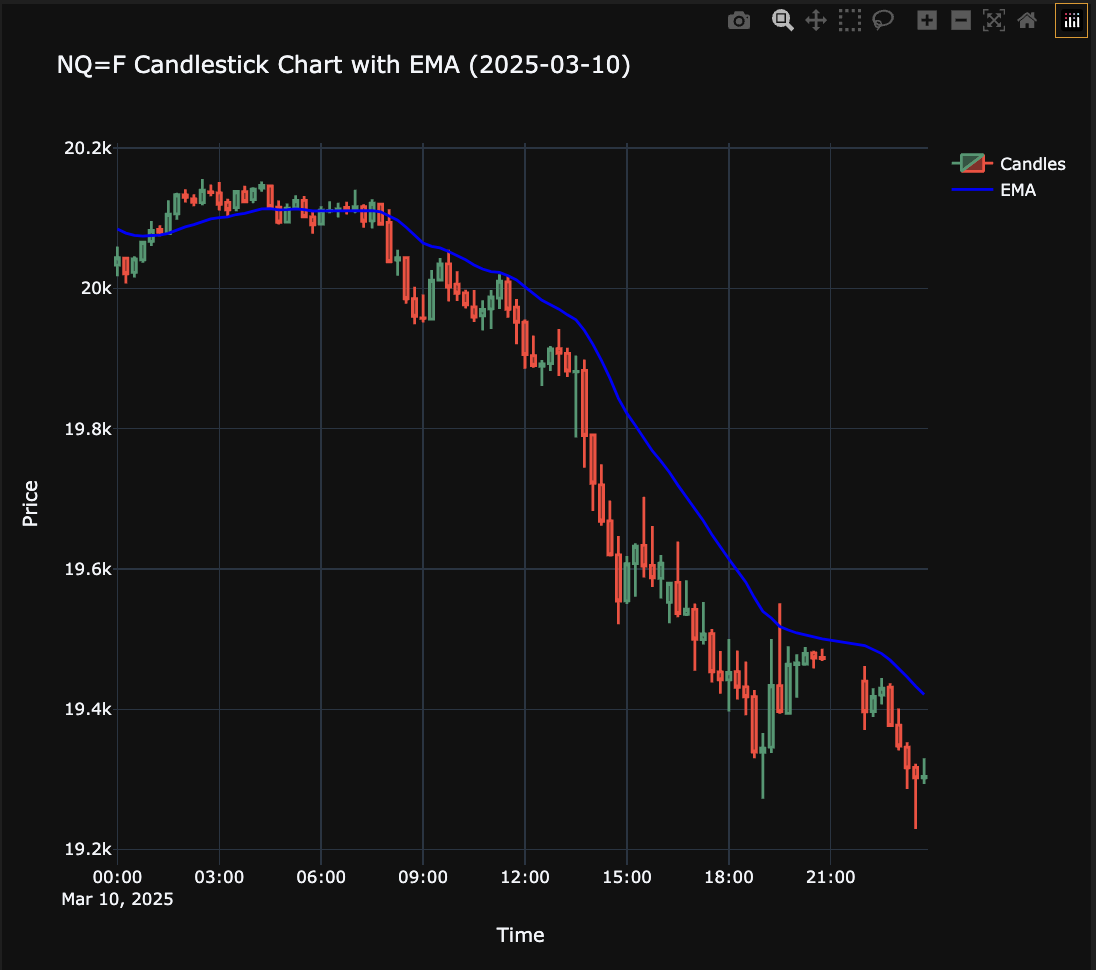

In [49]:
Image(filename= "graphsforgit/c2.png", height= 500, width= 800)

From what I've found so far, the reason why EMA is a viable indicator of when to buy and sell solely plays with psychology. (A self fufilling prophecy). This is why you'll see the commonly used EMAs be stronger than others. Since people believe that the EMA acts as support or resistance, there will be those who buy or sell at the EMA, this then is validated moreso by the people who have observed this happening and increase the confidence in the EMA. I think this essentially is my understanding of technical analysis so far. Patterns are inherently ingrained in nature, and moreover we as humans are wired to find patterns in things where patterns may not originally exist. Throughout my math classes I've been introduced to many naturally occuring patterns that are quite amazing such as the fibonacci sequence and the golden ratio. If these patterns are so strongly apparent in so many different aspects of nature-- they must also be apparent in the way we behave as well. The fibonacci trading strategy is one I will attempt to implement in the future.

### MACD (Moving Average Convergence Divergence) Indicator

Also an extremely well regarded technical indicator in making trading decisions. The MACD is a momentum and trend indicator. The MACD illustrates the relationship between two different EMAs (with the default on most trading platforms being 9-12-26).   
#### There are three parts to the MACD
* MACD Line : 12 EMA - 26 EMA (or whatever you'd like to input, 12 and 26 are just the defaults) The MACD line is the fast line.
* The Signal Line : The 9 (orwhatever) period EMA of the MACD line. Acting as the slow line
* Histogram: Showing the difference between the two.

The most common of buy/sell signals people use with the MACD is when the two lines cross. 
 - MACD crossing above the signal line would be a Bullish Signal
 - MACD crossing below the signal line would be a Bearish Signal
 - The Histogram lies on an axis as well staying above or below. So when the two lines cross the Histogram would flip sides, acting as a signal as well

In [50]:
def add_macd(df, short_window=12, long_window=26, signal_window=9, prefix=''):
    """
    Add MACD, Signal Line, and MACD Histogram to the DataFrame.

    Parameters:
    - df (DataFrame): Must contain a 'Close' column.
    - short_window (int): Short EMA period.
    - long_window (int): Long EMA period.
    - signal_window (int): Signal line EMA period.
    - prefix (str): Optional prefix to avoid column name collisions (e.g., for multiple MACDs).

    Returns:
    - df (DataFrame): With added columns: f'{prefix}MACD', f'{prefix}Signal_Line', f'{prefix}MACD_Hist'
    """
    close = df['Close']
    ema_short = close.ewm(span=short_window, adjust=False).mean()
    ema_long = close.ewm(span=long_window, adjust=False).mean()
    macd = ema_short - ema_long
    signal = macd.ewm(span=signal_window, adjust=False).mean()
    hist = macd - signal

    df[f'{prefix}MACD'] = macd
    df[f'{prefix}Signal_Line'] = signal
    df[f'{prefix}MACD_Hist'] = hist

    return df

nqdf = add_macd(nqdf, short_window=12, long_window=26, signal_window=9, prefix='')

In [51]:
def plot_candlestick_with_indicators(df, indicators=None, day=None, start_time=None, end_time=None):
    """
    Plot candlestick chart with auto-handled indicators including oscillators on a secondary y-axis.

    Parameters:
    - df: DataFrame with OHLC + indicator columns.
    - indicators: List of dicts: {'name': str, 'column': str, 'color': str (optional), 'type': 'trend' or 'oscillator' (optional)}
    - day, start_time, end_time: Optional filters.
    """
    df = df.copy()
    df.index = pd.to_datetime(df.index)
    df = df.dropna(subset=['Open', 'High', 'Low', 'Close'])

    # Filter by day
    if day is not None:
        day = pd.to_datetime(day).date()
        df = df[df.index.date == day]

    # Filter by time range
    if start_time or end_time:
        start_time = pd.to_datetime(start_time).time() if start_time else df.index.time.min()
        end_time = pd.to_datetime(end_time).time() if end_time else df.index.time.max()
        df = df[(df.index.time >= start_time) & (df.index.time <= end_time)]

    if df.empty:
        print("No data for the specified day/time range.")
        return

    # Define known oscillators
    known_oscillator_keywords = ['MACD', 'SIGNAL', 'RSI', 'STOCH', 'CCI']

    # Classify indicators by type
    trend_indicators = []
    oscillator_indicators = []

    for ind in indicators or []:
            name = ind.get('name', ind['column'])
            column = ind['column']
            color = ind.get('color', 'blue')
            ind_type = ind.get('type')

            # Smarter auto-detection
            if not ind_type:
                if any(kw in name.upper() or kw in column.upper() for kw in known_oscillator_keywords):
                    ind_type = 'oscillator'
                else:
                    ind_type = 'trend'

            # Add to the correct list
            if ind_type == 'oscillator':
                oscillator_indicators.append({**ind, 'name': name, 'column': column, 'color': color})
            else:
                trend_indicators.append({**ind, 'name': name, 'column': column, 'color': color})


    # Create subplot with or without second row
    has_oscillators = len(oscillator_indicators) > 0
    row_heights = [0.7, 0.3] if has_oscillators else [1.0]
    specs = [[{"secondary_y": False}]] if not has_oscillators else [[{"secondary_y": False}], [{"secondary_y": False}]]

    fig = make_subplots(rows=len(row_heights), cols=1,
                        shared_xaxes=True,
                        vertical_spacing=0.05,
                        row_heights=row_heights,
                        specs=specs)

    # Plot candlestick
    fig.add_trace(go.Candlestick(
        x=df.index,
        open=df['Open'],
        high=df['High'],
        low=df['Low'],
        close=df['Close'],
        name='Candles'
    ), row=1, col=1)

    # Plot trend indicators on main chart
    for ind in trend_indicators:
        if ind['column'] in df:
            fig.add_trace(go.Scatter(
                x=df.index,
                y=df[ind['column']],
                mode='lines',
                name=ind['name'],
                line=dict(color=ind['color'], width=2)
            ), row=1, col=1)

    # Plot oscillators below
    for ind in oscillator_indicators:
        if ind['column'] in df:
            fig.add_trace(go.Scatter(
                x=df.index,
                y=df[ind['column']],
                mode='lines',
                name=ind['name'],
                line=dict(color=ind['color'], width=2)
            ), row=2, col=1)

    fig.update_layout(
        title=f'Candlestick Chart with Indicators ({day})',
        xaxis_title='Time',
        yaxis_title='Price',
        template='plotly_dark',
        height=800 if has_oscillators else 700,
        xaxis_rangeslider_visible=False
    )

    fig.show('notebook')



In [52]:
nqdf

,Close,High,Low,Open,Volume,Signal,EMA,MACD,Signal_Line,MACD_Hist
0,21306.00,21348.50,21289.00,21301.50,1470,0,21306.000000,0.000000,0.000000,0.000000
1,21334.50,21344.25,21242.50,21302.50,4369,0,21308.590909,2.273504,0.454701,1.818803
2,21352.50,21361.50,21317.75,21333.50,2149,0,21312.582645,5.464728,1.456706,4.008022
3,21358.25,21410.00,21344.00,21354.25,2405,0,21316.734222,8.361389,2.837643,5.523746
4,21359.75,21374.75,21337.50,21359.25,1395,0,21320.644748,10.655223,4.401159,6.254064
...,...,...,...,...,...,...,...,...,...,...
3554,19380.00,19381.75,19364.75,19366.25,939,0,19350.019684,8.767421,9.419075,-0.651654
3555,19378.25,19386.75,19373.50,19380.25,778,0,19352.586076,10.031933,9.541647,0.490286
3556,19371.50,19379.25,19367.50,19379.25,665,0,19354.305524,10.369861,9.707290,0.662572
3557,19360.25,19374.25,19354.50,19372.50,1168,0,19354.845931,9.619009,9.689634,-0.070624


In [53]:

plot_candlestick_with_indicators(
    nqdf,
    indicators=[
        {'name': 'MACD', 'column': 'MACD', 'color': 'cyan'},
        {'name': 'Signal Line', 'column': 'Signal_Line', 'color': 'magenta'},
        {'name': 'EMA', 'column': 'EMA', 'color': 'orange'},
    ],
    day='2025-03-10',
    #start_time='09:30',
    #end_time='13:00'
)


No data for the specified day/time range.


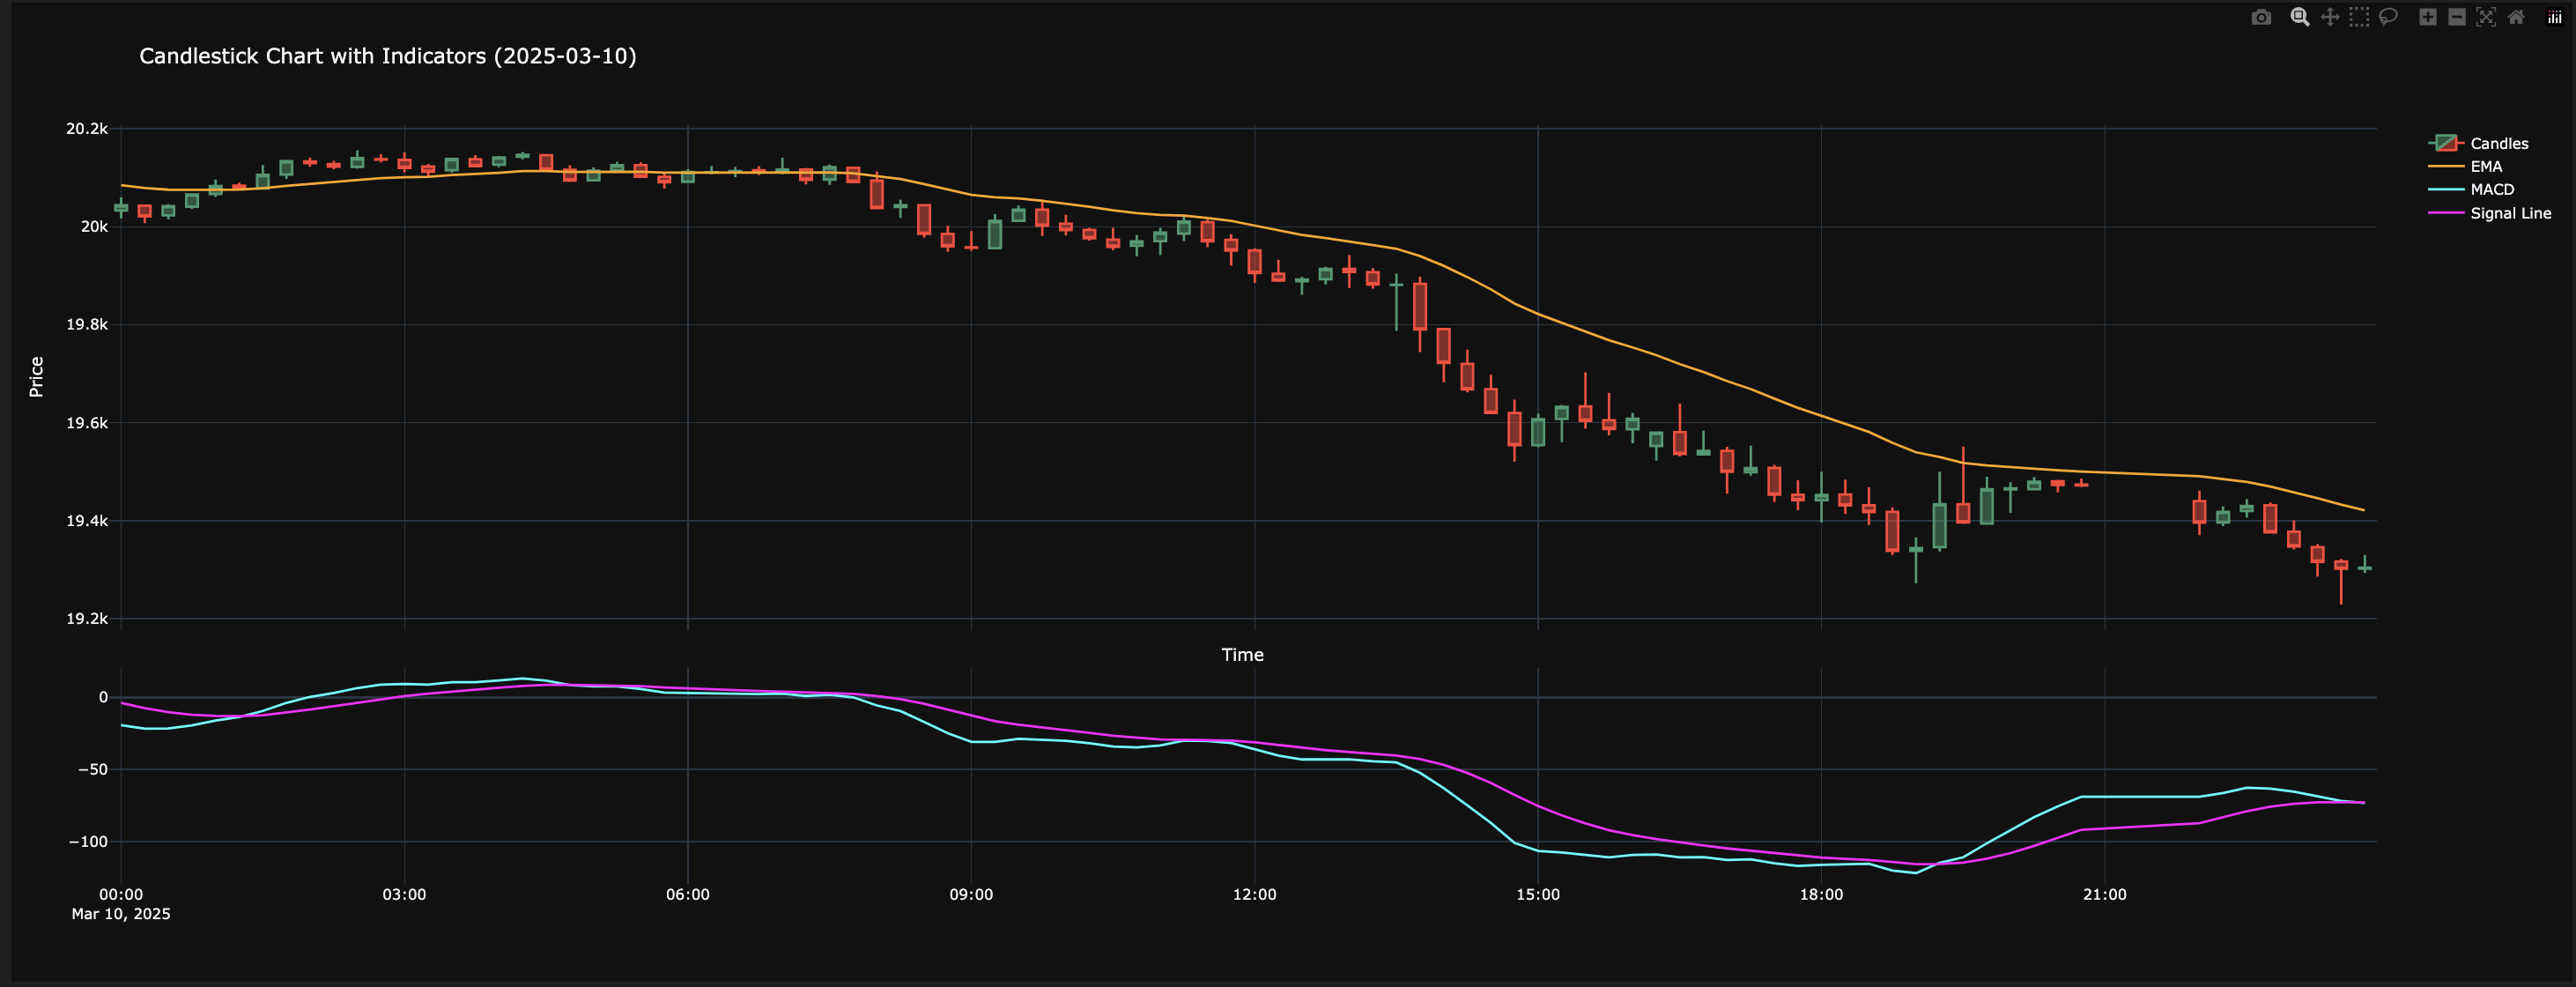

In [54]:
Image(filename = 'graphsforgit/c1.png')

So on this day, using MACD as an indicator we see that there is a clear MACD Crossover at 9:15, which resulted in a slight reversal to the upside. These indicators definitely work to show reversals-- but from experience, the art of trading comes from descretion and using these indicators with a grain of salt

In [56]:
nqdf.to_csv('nqdf.csv', index=True)